## Arima
from https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/

In [17]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
from IPython.core.display import HTML
HTML("<style>.container{ width: 100% !important; }</style>")

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 10)

In [9]:
from pandas import Series
series = Series.from_csv('data/champagne.csv', header=0)
split_point = len(series) - 12
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')


Dataset 94, Validation 12


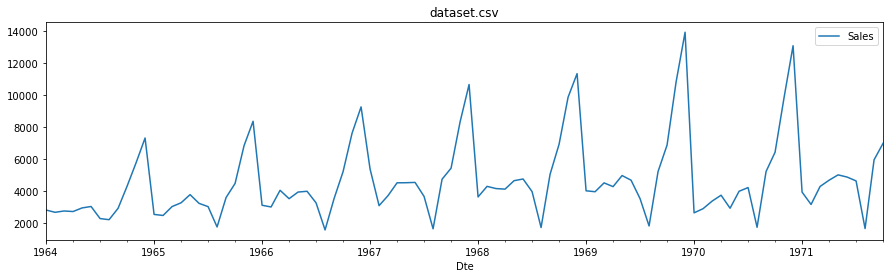

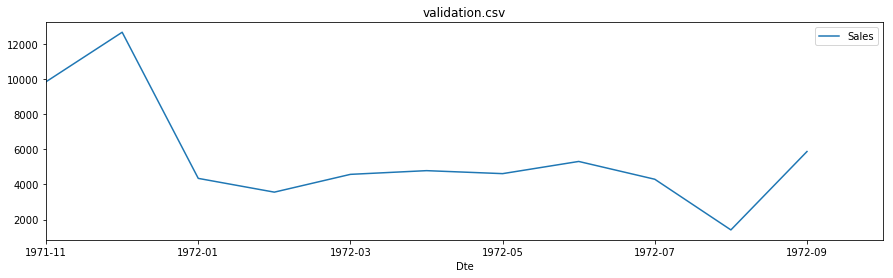

In [49]:
def myplot(csv):
    df = pd.read_csv(csv,header=None,parse_dates=[0])
    df.columns=['Dte','Sales']
    df.set_index("Dte").plot(figsize=(15,4),title=csv);

myplot('dataset.csv')
myplot('validation.csv')

## What's the accuracy of prior value?

In [54]:
from pandas import Series
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # predict
    yhat = history[-1]
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    if i > len(test)-6:
        print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)   
rmse = sqrt(mse)
print('RMSE accuracy: %.3f (amount we\'re typically off)' % rmse)
# to measure variance


>Predicted=5010.000, Expected=4874
>Predicted=4874.000, Expected=4633
>Predicted=4633.000, Expected=1659
>Predicted=1659.000, Expected=5951
>Predicted=5951.000, Expected=6981
RMSE accuracy: 3162.143 (amount we're typically off)


## Seasonality

subplot=711,i= 1
subplot=712,i= 2
subplot=713,i= 3
subplot=714,i= 4
subplot=715,i= 5
subplot=716,i= 6
subplot=717,i= 7


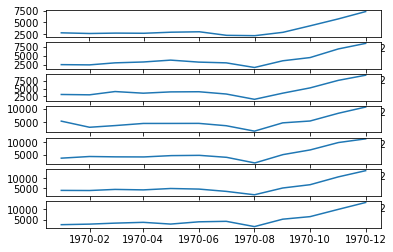

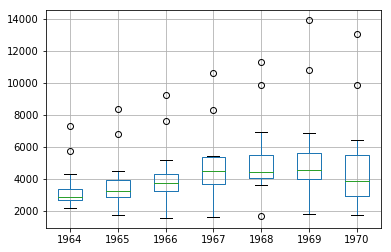

In [13]:
from pandas import Series
from pandas import DataFrame
from pandas import TimeGrouper
from matplotlib import pyplot

series = Series.from_csv('data/dataset.csv')
groups = series['1964':'1970'].groupby(TimeGrouper('A'))
years = DataFrame()
# pyplot.figure()
i = 1
n_groups = len(groups)
for name, group in groups:
    print("subplot={},i=".format((n_groups*100) + 10 + i),i)
    pyplot.subplot((n_groups*100) + 10 + i)
    i += 1
    pyplot.plot(group)
pyplot.show();

years = DataFrame()
for name, group in groups:
	years[name.year] = group.values
years.boxplot()
pyplot.show();

## Arima

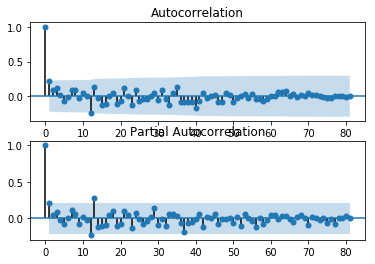

In [70]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = Series.from_csv('stationary.csv')
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show();

ADF Statistic: -7.180580
p-value: 0.000000
Critical Values:
	1%: -3.514
	5%: -2.898
	10%: -2.586


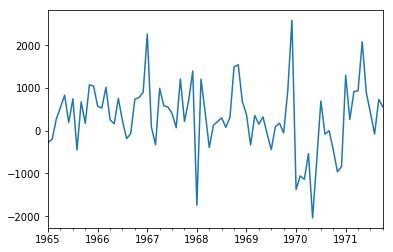

In [23]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 
series = Series.from_csv('dataset.csv')
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
stationary = difference(X, months_in_year)      # computes the difference amounts for same month of prior year
stationary.index = series.index[months_in_year:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv')
# plot
stationary.plot();
pyplot.show();

In [56]:
from pandas import Series
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(1,1,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
    if i > len(test)-5:
        print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=4624.998, Expected=4633
>Predicted=2044.098, Expected=1659
>Predicted=5404.428, Expected=5951
>Predicted=6804.425, Expected=6981
RMSE: 956.734


In [72]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		# difference data
		months_in_year = 12
		diff = difference(history, months_in_year)
		model = ARIMA(diff, order=arima_order)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		yhat = inverse_difference(history, yhat, months_in_year)
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
series = Series.from_csv('dataset.csv')
# evaluate parameters
p_values = range(0, 7)
d_values = range(0, 3)
q_values = range(0, 7)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=933.954
ARIMA(0, 0, 2) RMSE=960.443
ARIMA(0, 0, 3) RMSE=943.894
ARIMA(0, 0, 4) RMSE=957.668
ARIMA(0, 0, 5) RMSE=987.148
ARIMA(0, 0, 6) RMSE=1088.200
ARIMA(0, 1, 1) RMSE=957.960
ARIMA(0, 2, 1) RMSE=1145.504
ARIMA(1, 0, 0) RMSE=941.572
ARIMA(1, 1, 0) RMSE=1070.469
ARIMA(1, 1, 1) RMSE=956.734
ARIMA(1, 2, 0) RMSE=1555.966
ARIMA(2, 0, 0) RMSE=955.363
ARIMA(2, 1, 0) RMSE=1029.710
ARIMA(2, 1, 1) RMSE=980.478
ARIMA(2, 2, 0) RMSE=1346.554
ARIMA(2, 2, 1) RMSE=1039.184
ARIMA(3, 0, 0) RMSE=957.986
ARIMA(3, 1, 0) RMSE=1027.364
ARIMA(3, 1, 1) RMSE=979.389
ARIMA(3, 2, 0) RMSE=1249.541
ARIMA(4, 0, 0) RMSE=967.274
ARIMA(4, 1, 0) RMSE=1045.708
ARIMA(4, 1, 1) RMSE=1005.806
ARIMA(4, 2, 0) RMSE=1229.438
ARIMA(4, 2, 1) RMSE=1054.998
ARIMA(5, 0, 0) RMSE=987.288
ARIMA(5, 1, 0) RMSE=1042.012
ARIMA(5, 1, 1) RMSE=1024.013
ARIMA(5, 2, 1) RMSE=1053.393
ARIMA(6, 0, 0) RMSE=996.320
ARIMA(6, 1, 0) RMSE=1017.993
ARIMA(6, 1, 1) RMSE=1024.034
ARIMA(6, 1, 2) RMSE=1033.412
Best ARIMA(0, 0, 1) RMSE=933.

In [97]:
import statsmodels.api as sm
sm.version.version

'0.8.0'

In [75]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
import numpy
 
# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
 
ARIMA.__getnewargs__ = __getnewargs__
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
# difference data
months_in_year = 12
diff = difference(X, months_in_year)
# fit model
model = ARIMA(diff, order=(0,0,1))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = 165.904728
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

>Predicted=10101.763, Expected=9851
>Predicted=13219.067, Expected=12670
>Predicted=3996.535, Expected=4348
>Predicted=3465.934, Expected=3564
>Predicted=4522.683, Expected=4577
>Predicted=4901.336, Expected=4788
>Predicted=5190.094, Expected=4618
>Predicted=4930.190, Expected=5312
>Predicted=4944.785, Expected=4298
>Predicted=1699.409, Expected=1413
>Predicted=6085.324, Expected=5877
RMSE: 372.964


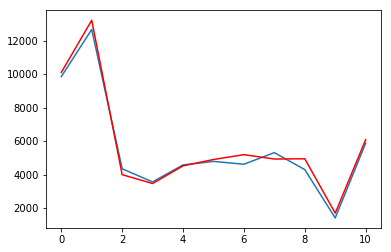

Wall time: 225 ms


In [94]:
%%time

from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return diff
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# load and prepare datasets
dataset = Series.from_csv('dataset.csv')
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
validation = Series.from_csv('validation.csv')
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')


# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = bias + inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=(0,0,1))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = bias + inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

# report performance
# print
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show();